/home/grtsinry43/.conda/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 数据集概览 ---
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0       

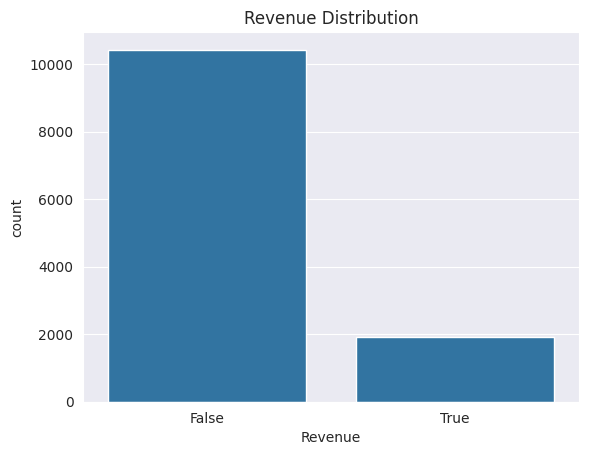

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

try:
    df = pd.read_csv("hf://datasets/schooly/online-shoppers-intention/online_shoppers_intention.csv")
except FileNotFoundError:
    print(f"错误: 数据集联网加载失败")
    exit()

# --- 初步数据探索 ---
print("--- 数据集概览 ---")
print(df.head())
print("\n--- 数据信息 ---")
df.info()
print("\n--- 描述性统计 ---")
print(df.describe())
print("\n--- 缺失值检查 ---")
print(df.isnull().sum())

# 目标变量分布
print("\n--- 目标变量 'Revenue' 分布 ---")
print(df['Revenue'].value_counts(normalize=True))
sns.countplot(x='Revenue', data=df)
plt.title('Revenue Distribution')
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- 数据预处理 ---
# 将布尔值转换为整数
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)  # 目标变量

# 识别类别特征和数值特征
categorical_features = ['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
# 'OperatingSystems', 'Browser', 'Region', 'TrafficType' 是数值类型，但它们代表类别，所以也当类别处理
# 确保将这些数值型类别特征转换为字符串类型，以便OneHotEncoder正确处理
for col in ['OperatingSystems', 'Browser', 'Region', 'TrafficType']:
    df[col] = df[col].astype(str)

numerical_features = ['Administrative', 'Administrative_Duration', 'Informational',
                      'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                      'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

# 创建预处理器
# 对于数值特征：进行标准化
# 对于类别特征：进行独热编码 (One-Hot Encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # 保留其他未指定列 (如 'Weekend', 'Revenue')
)

# 分离特征和目标变量
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# 应用预处理
# 注意：ColumnTransformer 会改变列的顺序和数量
X_processed = preprocessor.fit_transform(X)

# 如果 X_processed 是稀疏矩阵，转换为密集数组
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

print(f"\n--- 处理后的特征维度 ---")
print(X_processed.shape)

# 划分训练集和测试集
# 这里的 random_state 是为了结果可复现
X_train, X_test, y_train, y_test = train_test_split(X_processed, y.values, test_size=0.2, random_state=42, stratify=y)

print(f"训练集大小: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"测试集大小: X_test: {X_test.shape}, y_test: {y_test.shape}")


--- 处理后的特征维度 ---
(12330, 74)
训练集大小: X_train: (9864, 74), y_train: (9864,)
测试集大小: X_test: (2466, 74), y_test: (2466,)


In [3]:
import numpy as np


# --- 从零实现逻辑回归 ---
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, verbose=False):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.verbose = verbose  # 是否打印训练过程中的损失
        self.costs = []  # 记录每次迭代的损失

    def _sigmoid(self, z):
        # 防止溢出
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # 初始化权重和偏置
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.costs = []

        # 梯度下降
        for i in range(self.n_iterations):
            # 线性模型: z = X.w + b
            linear_model = np.dot(X, self.weights) + self.bias
            # 应用sigmoid函数得到预测概率
            y_predicted_proba = self._sigmoid(linear_model)

            # 计算梯度
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted_proba - y))
            db = (1 / n_samples) * np.sum(y_predicted_proba - y)

            # 更新权重和偏置
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # 计算并记录损失 (Binary Cross-Entropy)
            # 添加一个小的epsilon防止log(0)
            epsilon = 1e-9
            cost = - (1 / n_samples) * np.sum(
                y * np.log(y_predicted_proba + epsilon) + (1 - y) * np.log(1 - y_predicted_proba + epsilon))
            self.costs.append(cost)

            if self.verbose and (i % (self.n_iterations // 10) == 0 or i == self.n_iterations - 1):
                print(f"Iteration {i}, Cost: {cost:.4f}")

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        y_predicted_proba = self.predict_proba(X)
        y_predicted_labels = [1 if i > threshold else 0 for i in y_predicted_proba]
        return np.array(y_predicted_labels)


# 其他可选算法框架 (你需要填充实现细节):
class MyDecisionTree:  # (ID3, C4.5, CART等)
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        # ... (实现计算熵/基尼不纯度、信息增益/增益率、树的构建、预测等) ...

    def fit(self, X, y):
        # ...
        pass

    def predict(self, X):
        # ...
        pass


class MyKNearestNeighbors:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
        # ... (实现距离计算，找到k个最近邻，投票等) ...

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X_test):
        predictions = [self._predict_single(x) for x in X_test]
        return np.array(predictions)

    def _predict_single(self, x):
        distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # 多数投票
        from collections import Counter
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]


--- 训练自定义逻辑回归模型 ---
Iteration 0, Cost: 0.6931
Iteration 200, Cost: 0.2972
Iteration 400, Cost: 0.2903
Iteration 600, Cost: 0.2883
Iteration 800, Cost: 0.2873
Iteration 1000, Cost: 0.2867
Iteration 1200, Cost: 0.2864
Iteration 1400, Cost: 0.2861
Iteration 1600, Cost: 0.2859
Iteration 1800, Cost: 0.2857
Iteration 1999, Cost: 0.2856


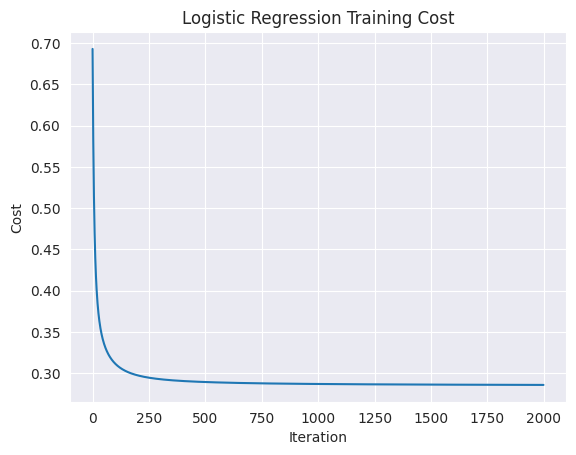

In [4]:
# --- 训练自定义逻辑回归模型 ---
print("\n--- 训练自定义逻辑回归模型 ---")
log_reg_model = MyLogisticRegression(learning_rate=0.1, n_iterations=2000, verbose=True)  # 调整参数
log_reg_model.fit(X_train, y_train)

# 绘制损失曲线
plt.figure()
plt.plot(range(len(log_reg_model.costs)), log_reg_model.costs)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Logistic Regression Training Cost")
plt.show()

# --- 进行预测 ---
y_pred_proba = log_reg_model.predict_proba(X_test)  # 获取概率用于ROC曲线
y_pred_labels = log_reg_model.predict(X_test)  # 获取类别标签


--- 模型评估 ---
Accuracy: 0.8832

Classification Report👀:
                  precision    recall  f1-score   support

Will Not Buy (0)       0.89      0.98      0.93      2084
    Will Buy (1)       0.76      0.36      0.49       382

        accuracy                           0.88      2466
       macro avg       0.83      0.67      0.71      2466
    weighted avg       0.87      0.88      0.87      2466


混淆矩阵:


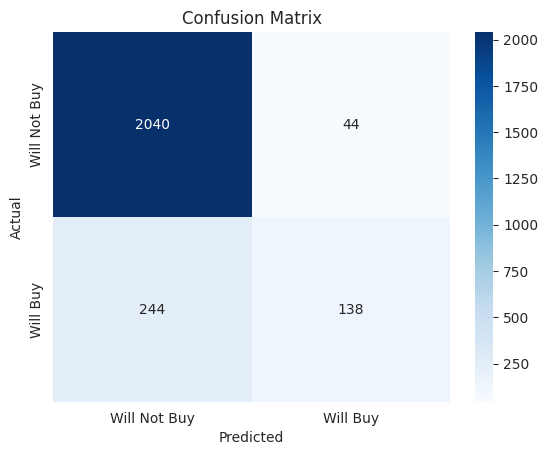

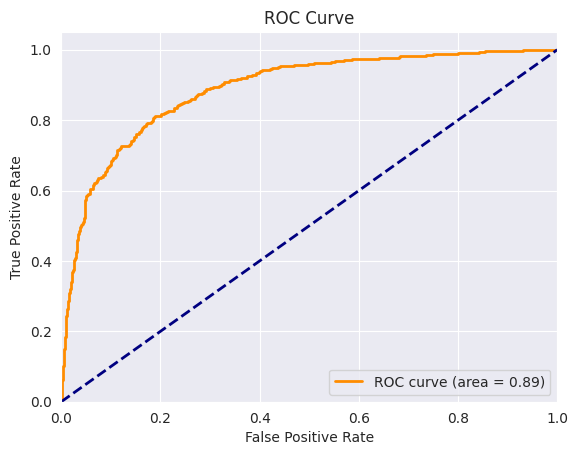

AUC: 0.8881


In [5]:
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report

print("\n--- 模型评估 ---")
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels, target_names=['Will Not Buy (0)', 'Will Buy (1)']))

print("\n混淆矩阵:")
cm = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")

In [15]:
import numpy as np
from tqdm import tqdm
import time


def linear_kernel(X1, X2):
    return np.dot(X1, X2.T)


def rbf_kernel(X1, X2, gamma=0.1):
    if X1.ndim == 1:
        X1 = X1[np.newaxis, :]
    if X2.ndim == 1:
        X2 = X2[np.newaxis, :]
    sq_dists = np.sum(X1 ** 2, axis=1)[:, None] + np.sum(X2 ** 2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)


class SMO_SVM:
    def __init__(self, C=1.0, kernel='rbf', gamma=0.1, tol=1e-3, max_passes=5):
        self.C = C
        self.gamma = gamma
        self.tol = tol
        self.max_passes = max_passes
        self.kernel = rbf_kernel if kernel == 'rbf' else linear_kernel
        self.alphas = None
        self.b = 0
        self.X = None
        self.y = None

    def fit(self, X, y):
        y = np.where(y <= 0, -1, 1)
        n_samples, n_features = X.shape
        self.X = X
        self.y = y
        self.alphas = np.zeros(n_samples)
        self.b = 0
        passes = 0
        K = self.kernel(X, X) if self.kernel != rbf_kernel else rbf_kernel(X, X, self.gamma)

        with tqdm(total=self.max_passes, desc="SVM Training Progress") as pbar:
            while passes < self.max_passes:
                alpha_changed = 0
                print(f"\nPass {passes + 1}/{self.max_passes}")
                start_time = time.time()
                for i in range(n_samples):
                    Ei = self._E(i, K)
                    if (y[i] * Ei < -self.tol and self.alphas[i] < self.C) or (
                            y[i] * Ei > self.tol and self.alphas[i] > 0):
                        j = np.random.choice([x for x in range(n_samples) if x != i])
                        Ej = self._E(j, K)

                        alpha_i_old = self.alphas[i].copy()
                        alpha_j_old = self.alphas[j].copy()

                        if y[i] != y[j]:
                            L = max(0, self.alphas[j] - self.alphas[i])
                            H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                        else:
                            L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                            H = min(self.C, self.alphas[i] + self.alphas[j])
                        if L == H:
                            continue

                        eta = 2 * K[i, j] - K[i, i] - K[j, j]
                        if eta >= 0:
                            continue

                        self.alphas[j] -= y[j] * (Ei - Ej) / eta
                        self.alphas[j] = np.clip(self.alphas[j], L, H)

                        if abs(self.alphas[j] - alpha_j_old) < 1e-5:
                            continue

                        self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

                        b1 = self.b - Ei - y[i] * (self.alphas[i] - alpha_i_old) * K[i, i] - y[j] * (
                                self.alphas[j] - alpha_j_old) * K[i, j]
                        b2 = self.b - Ej - y[i] * (self.alphas[i] - alpha_i_old) * K[i, j] - y[j] * (
                                self.alphas[j] - alpha_j_old) * K[j, j]

                        if 0 < self.alphas[i] < self.C:
                            self.b = b1
                        elif 0 < self.alphas[j] < self.C:
                            self.b = b2
                        else:
                            self.b = (b1 + b2) / 2

                        alpha_changed += 1

                    # # Add detailed log for each sample
                    # if i % 100 == 0 or i == n_samples - 1:
                    #     print(f"  Sample {i + 1}/{n_samples}, alpha_changed: {alpha_changed}")

                print(
                    f"Pass {passes + 1} finished, alpha_changed: {alpha_changed}, time: {time.time() - start_time:.2f}s")
                if alpha_changed == 0:
                    passes += 1
                    pbar.update(1)
                else:
                    passes = 0

    def _E(self, i, K):
        return self._f(i, K) - self.y[i]

    def _f(self, i, K):
        return np.sum(self.alphas * self.y * K[:, i]) + self.b

    def project(self, X):
        K = self.kernel(self.X, X) if self.kernel != rbf_kernel else rbf_kernel(self.X, X, self.gamma)
        return (self.alphas * self.y) @ K + self.b

    def predict(self, X):
        return np.where(self.project(X) >= 0, 1, 0)


--- 训练自定义线性SVM模型 ---


SVM Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Pass 1/5
Pass 1 finished, alpha_changed: 937, time: 2.84s

Pass 1/5
Pass 1 finished, alpha_changed: 1036, time: 2.49s

Pass 1/5
Pass 1 finished, alpha_changed: 1176, time: 2.49s

Pass 1/5
Pass 1 finished, alpha_changed: 1297, time: 2.48s

Pass 1/5
Pass 1 finished, alpha_changed: 1343, time: 2.55s

Pass 1/5
Pass 1 finished, alpha_changed: 1340, time: 2.51s

Pass 1/5
Pass 1 finished, alpha_changed: 1404, time: 2.57s

Pass 1/5
Pass 1 finished, alpha_changed: 1366, time: 2.46s

Pass 1/5
Pass 1 finished, alpha_changed: 1299, time: 2.35s

Pass 1/5
Pass 1 finished, alpha_changed: 1235, time: 2.29s

Pass 1/5
Pass 1 finished, alpha_changed: 1180, time: 2.28s

Pass 1/5
Pass 1 finished, alpha_changed: 1094, time: 2.18s

Pass 1/5
Pass 1 finished, alpha_changed: 1067, time: 2.11s

Pass 1/5
Pass 1 finished, alpha_changed: 1006, time: 2.09s

Pass 1/5
Pass 1 finished, alpha_changed: 994, time: 2.02s

Pass 1/5
Pass 1 finished, alpha_changed: 903, time: 2.04s

Pass 1/5
Pass 1 finished, alpha_changed: 8

SVM Training Progress:  20%|██        | 1/5 [11:30<46:00, 690.01s/it]

Pass 1 finished, alpha_changed: 0, time: 0.35s

Pass 2/5
Pass 2 finished, alpha_changed: 7, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 22, time: 0.40s

Pass 1/5
Pass 1 finished, alpha_changed: 14, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 13, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 13, time: 0.39s

Pass 1/5
Pass 1 finished, alpha_changed: 18, time: 0.40s

Pass 1/5
Pass 1 finished, alpha_changed: 13, time: 0.39s

Pass 1/5
Pass 1 finished, alpha_changed: 17, time: 0.41s

Pass 1/5
Pass 1 finished, alpha_changed: 22, time: 0.42s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.39s

Pass 1/5
Pass 1 finished, alpha_changed: 15, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 14, time: 0.41s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.37s

Pass 1/5
Pass 1 finished, alp

SVM Training Progress:  40%|████      | 2/5 [13:22<17:30, 350.32s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 10, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 12, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 18, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_ch

SVM Training Progress:  60%|██████    | 3/5 [14:04<06:58, 209.45s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 16, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 12, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 12, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_ch

SVM Training Progress:  80%|████████  | 4/5 [14:16<02:11, 131.60s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 3, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 17, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 14, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 12, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.33s

Pass 1/5


SVM Training Progress: 100%|██████████| 5/5 [14:22<00:00, 86.27s/it] 

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 3, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 15, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_chan

SVM Training Progress: 6it [14:47, 65.27s/it]                       

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 7, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5


SVM Training Progress: 7it [14:51, 45.41s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 10, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 13, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 13, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_cha

SVM Training Progress: 8it [15:00, 33.66s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 3, time: 0.35s

Pass 1/5


SVM Training Progress: 9it [15:00, 23.36s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 11, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 14, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5


SVM Training Progress: 10it [15:06, 17.90s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 2, time: 0.34s

Pass 1/5


SVM Training Progress: 11it [15:07, 12.63s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 3, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5


SVM Training Progress: 12it [15:10,  9.74s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5


SVM Training Progress: 13it [15:12,  7.42s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 2, time: 0.32s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.34s

Pass 1/5


SVM Training Progress: 14it [15:14,  5.78s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5
Pass 2 finished, alpha_changed: 11, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_change

SVM Training Progress: 15it [15:26,  7.86s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5


SVM Training Progress: 16it [15:27,  5.59s/it]

Pass 2 finished, alpha_changed: 0, time: 0.33s

Pass 3/5
Pass 3 finished, alpha_changed: 8, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.39s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed:

SVM Training Progress: 17it [15:33,  5.82s/it]

Pass 1 finished, alpha_changed: 0, time: 0.35s

Pass 2/5
Pass 2 finished, alpha_changed: 5, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.36s

Pass 1/5


SVM Training Progress: 18it [15:35,  4.72s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 5, time: 0.33s

Pass 1/5


SVM Training Progress: 19it [15:36,  3.50s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5


SVM Training Progress: 20it [15:36,  2.56s/it]

Pass 2 finished, alpha_changed: 0, time: 0.36s

Pass 3/5
Pass 3 finished, alpha_changed: 7, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.32s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5


SVM Training Progress: 21it [15:41,  3.33s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5


SVM Training Progress: 22it [15:42,  2.43s/it]

Pass 2 finished, alpha_changed: 0, time: 0.32s

Pass 3/5
Pass 3 finished, alpha_changed: 3, time: 0.34s

Pass 1/5


SVM Training Progress: 23it [15:42,  1.90s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 6, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.33s

Pass 1/5


SVM Training Progress: 24it [15:43,  1.63s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.32s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5


SVM Training Progress: 25it [15:47,  2.27s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5


SVM Training Progress: 26it [15:48,  1.69s/it]

Pass 2 finished, alpha_changed: 0, time: 0.32s

Pass 3/5
Pass 3 finished, alpha_changed: 11, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.34s

Pass 1/5


SVM Training Progress: 27it [15:49,  1.49s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 12, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 18, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.32s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 9, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_change

SVM Training Progress: 28it [15:56,  3.30s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5
Pass 2 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.35s

Pass 1/5


SVM Training Progress: 29it [15:58,  2.82s/it]

Pass 1 finished, alpha_changed: 0, time: 0.36s

Pass 2/5
Pass 2 finished, alpha_changed: 4, time: 0.37s

Pass 1/5


SVM Training Progress: 30it [15:59,  2.18s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5
Pass 2 finished, alpha_changed: 2, time: 0.34s

Pass 1/5


SVM Training Progress: 31it [15:59,  1.73s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5


SVM Training Progress: 32it [16:00,  1.31s/it]

Pass 2 finished, alpha_changed: 0, time: 0.34s

Pass 3/5


SVM Training Progress: 33it [16:00,  1.02s/it]

Pass 3 finished, alpha_changed: 0, time: 0.34s

Pass 4/5


SVM Training Progress: 34it [16:00,  1.22it/s]

Pass 4 finished, alpha_changed: 0, time: 0.35s

Pass 5/5
Pass 5 finished, alpha_changed: 3, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.33s

Pass 1/5


SVM Training Progress: 35it [16:02,  1.19s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5


SVM Training Progress: 36it [16:03,  1.08it/s]

Pass 2 finished, alpha_changed: 0, time: 0.33s

Pass 3/5
Pass 3 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.33s

Pass 1/5


SVM Training Progress: 37it [16:05,  1.49s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5


SVM Training Progress: 38it [16:06,  1.14s/it]

Pass 2 finished, alpha_changed: 0, time: 0.32s

Pass 3/5
Pass 3 finished, alpha_changed: 3, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.36s

Pass 1/5


SVM Training Progress: 39it [16:07,  1.11s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5


SVM Training Progress: 40it [16:07,  1.15it/s]

Pass 2 finished, alpha_changed: 0, time: 0.32s

Pass 3/5
Pass 3 finished, alpha_changed: 5, time: 0.34s

Pass 1/5


SVM Training Progress: 41it [16:08,  1.23it/s]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 5, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.36s

Pass 1/5


SVM Training Progress: 42it [16:10,  1.31s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.37s

Pass 1/5


SVM Training Progress: 43it [16:12,  1.33s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5


SVM Training Progress: 44it [16:12,  1.03s/it]

Pass 2 finished, alpha_changed: 0, time: 0.33s

Pass 3/5


SVM Training Progress: 45it [16:12,  1.21it/s]

Pass 3 finished, alpha_changed: 0, time: 0.34s

Pass 4/5


SVM Training Progress: 46it [16:13,  1.47it/s]

Pass 4 finished, alpha_changed: 0, time: 0.34s

Pass 5/5
Pass 5 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.34s

Pass 1/5


SVM Training Progress: 47it [16:15,  1.22s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5


SVM Training Progress: 48it [16:15,  1.05it/s]

Pass 2 finished, alpha_changed: 0, time: 0.34s

Pass 3/5


SVM Training Progress: 49it [16:16,  1.30it/s]

Pass 3 finished, alpha_changed: 0, time: 0.33s

Pass 4/5


SVM Training Progress: 50it [16:16,  1.57it/s]

Pass 4 finished, alpha_changed: 0, time: 0.34s

Pass 5/5
Pass 5 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5


SVM Training Progress: 51it [16:17,  1.32it/s]

Pass 1 finished, alpha_changed: 0, time: 0.35s

Pass 2/5
Pass 2 finished, alpha_changed: 5, time: 0.38s

Pass 1/5


SVM Training Progress: 52it [16:18,  1.35it/s]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5


SVM Training Progress: 53it [16:18,  1.62it/s]

Pass 2 finished, alpha_changed: 0, time: 0.33s

Pass 3/5


SVM Training Progress: 54it [16:18,  1.88it/s]

Pass 3 finished, alpha_changed: 0, time: 0.34s

Pass 4/5
Pass 4 finished, alpha_changed: 4, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5


SVM Training Progress: 55it [16:20,  1.26it/s]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5


SVM Training Progress: 56it [16:20,  1.53it/s]

Pass 2 finished, alpha_changed: 0, time: 0.33s

Pass 3/5


SVM Training Progress: 57it [16:21,  1.79it/s]

Pass 3 finished, alpha_changed: 0, time: 0.33s

Pass 4/5


SVM Training Progress: 58it [16:21,  2.06it/s]

Pass 4 finished, alpha_changed: 0, time: 0.32s

Pass 5/5
Pass 5 finished, alpha_changed: 7, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.40s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.34s

Pass 1/5


SVM Training Progress: 59it [16:24,  1.29s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 4, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5


SVM Training Progress: 60it [16:25,  1.21s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 6, time: 0.35s

Pass 1/5


SVM Training Progress: 61it [16:26,  1.05s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 5, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 11, time: 0.38s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 10, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_chang

SVM Training Progress: 62it [16:32,  2.74s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5


SVM Training Progress: 63it [16:33,  2.02s/it]

Pass 2 finished, alpha_changed: 0, time: 0.34s

Pass 3/5
Pass 3 finished, alpha_changed: 5, time: 0.35s

Pass 1/5


SVM Training Progress: 64it [16:33,  1.61s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 3, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.37s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.34s

Pass 1/5


SVM Training Progress: 65it [16:37,  2.18s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5


SVM Training Progress: 66it [16:37,  1.62s/it]

Pass 2 finished, alpha_changed: 0, time: 0.32s

Pass 3/5


SVM Training Progress: 67it [16:38,  1.24s/it]

Pass 3 finished, alpha_changed: 0, time: 0.33s

Pass 4/5
Pass 4 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.36s

Pass 1/5


SVM Training Progress: 68it [16:39,  1.18s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5


SVM Training Progress: 69it [16:39,  1.08it/s]

Pass 2 finished, alpha_changed: 0, time: 0.34s

Pass 3/5


SVM Training Progress: 70it [16:39,  1.34it/s]

Pass 3 finished, alpha_changed: 0, time: 0.33s

Pass 4/5
Pass 4 finished, alpha_changed: 2, time: 0.35s

Pass 1/5


SVM Training Progress: 71it [16:40,  1.37it/s]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5


SVM Training Progress: 72it [16:40,  1.63it/s]

Pass 2 finished, alpha_changed: 0, time: 0.34s

Pass 3/5
Pass 3 finished, alpha_changed: 2, time: 0.35s

Pass 1/5


SVM Training Progress: 73it [16:41,  1.56it/s]

Pass 1 finished, alpha_changed: 0, time: 0.36s

Pass 2/5
Pass 2 finished, alpha_changed: 4, time: 0.37s

Pass 1/5


SVM Training Progress: 74it [16:42,  1.50it/s]

Pass 1 finished, alpha_changed: 0, time: 0.35s

Pass 2/5
Pass 2 finished, alpha_changed: 7, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.32s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.38s

Pass 1/5


SVM Training Progress: 75it [16:44,  1.01s/it]

Pass 1 finished, alpha_changed: 0, time: 0.39s

Pass 2/5
Pass 2 finished, alpha_changed: 6, time: 0.35s

Pass 1/5


SVM Training Progress: 76it [16:44,  1.10it/s]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 1, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.34s

Pass 1/5


SVM Training Progress: 77it [16:45,  1.06it/s]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 2, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5


SVM Training Progress: 78it [16:47,  1.05s/it]

Pass 1 finished, alpha_changed: 0, time: 0.32s

Pass 2/5


SVM Training Progress: 79it [16:47,  1.20it/s]

Pass 2 finished, alpha_changed: 0, time: 0.32s

Pass 3/5


SVM Training Progress: 80it [16:47,  1.47it/s]

Pass 3 finished, alpha_changed: 0, time: 0.32s

Pass 4/5
Pass 4 finished, alpha_changed: 1, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.36s

Pass 1/5


SVM Training Progress: 81it [16:48,  1.27it/s]

Pass 1 finished, alpha_changed: 0, time: 0.35s

Pass 2/5
Pass 2 finished, alpha_changed: 2, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 8, time: 0.39s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.39s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 3, time: 0.35s

Pass 1/5


SVM Training Progress: 82it [16:51,  1.41s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 4, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5


SVM Training Progress: 83it [16:53,  1.60s/it]

Pass 1 finished, alpha_changed: 0, time: 0.34s

Pass 2/5
Pass 2 finished, alpha_changed: 2, time: 0.33s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.33s

Pass 1/5


SVM Training Progress: 84it [16:54,  1.42s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 1, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 5, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 7, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 4, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 6, time: 0.35s

Pass 1/5


SVM Training Progress: 85it [16:57,  1.83s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 5, time: 0.34s

Pass 1/5


SVM Training Progress: 86it [16:58,  1.48s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5


SVM Training Progress: 87it [16:58,  1.14s/it]

Pass 2 finished, alpha_changed: 0, time: 0.34s

Pass 3/5


SVM Training Progress: 88it [16:58,  1.11it/s]

Pass 3 finished, alpha_changed: 0, time: 0.34s

Pass 4/5


SVM Training Progress: 89it [16:59,  1.37it/s]

Pass 4 finished, alpha_changed: 0, time: 0.34s

Pass 5/5
Pass 5 finished, alpha_changed: 2, time: 0.34s

Pass 1/5


SVM Training Progress: 90it [16:59,  1.39it/s]

Pass 1 finished, alpha_changed: 0, time: 0.35s

Pass 2/5
Pass 2 finished, alpha_changed: 1, time: 0.35s

Pass 1/5
Pass 1 finished, alpha_changed: 12, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 2, time: 0.36s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.34s

Pass 1/5


SVM Training Progress: 91it [17:01,  1.03s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5
Pass 2 finished, alpha_changed: 1, time: 0.34s

Pass 1/5
Pass 1 finished, alpha_changed: 1, time: 0.34s

Pass 1/5


SVM Training Progress: 92it [17:02,  1.02s/it]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5


SVM Training Progress: 93it [17:02,  1.23it/s]

Pass 2 finished, alpha_changed: 0, time: 0.33s

Pass 3/5


SVM Training Progress: 94it [17:03,  1.49it/s]

Pass 3 finished, alpha_changed: 0, time: 0.33s

Pass 4/5
Pass 4 finished, alpha_changed: 2, time: 0.33s

Pass 1/5


SVM Training Progress: 95it [17:03,  1.50it/s]

Pass 1 finished, alpha_changed: 0, time: 0.33s

Pass 2/5


SVM Training Progress: 96it [17:04,  1.76it/s]

Pass 2 finished, alpha_changed: 0, time: 0.33s

Pass 3/5


SVM Training Progress: 97it [17:04,  2.01it/s]

Pass 3 finished, alpha_changed: 0, time: 0.33s

Pass 4/5


SVM Training Progress: 98it [17:04,  2.23it/s]

Pass 4 finished, alpha_changed: 0, time: 0.34s

Pass 5/5


SVM Training Progress: 99it [17:05, 10.36s/it]

Pass 5 finished, alpha_changed: 0, time: 0.40s

--- SVM模型评估 ---
Accuracy: 0.8856

Classification Report👀:
                  precision    recall  f1-score   support

Will Not Buy (0)       0.91      0.96      0.93      2084
    Will Buy (1)       0.70      0.46      0.56       382

        accuracy                           0.89      2466
       macro avg       0.80      0.71      0.74      2466
    weighted avg       0.87      0.89      0.88      2466


混淆矩阵:


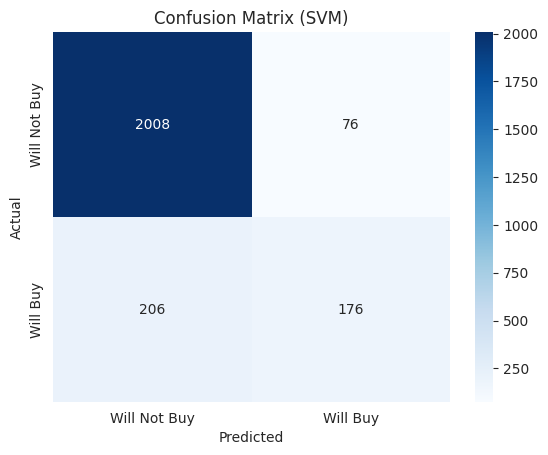

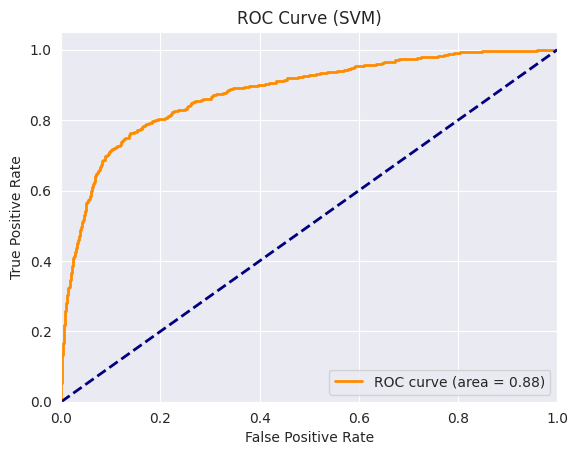

AUC: 0.8787


In [16]:
# --- 训练自定义线性SVM模型 ---
print("\n--- 训练自定义线性SVM模型 ---")
svm_model = SMO_SVM(C=1.0, kernel='rbf', tol=1e-3, max_passes=5)
svm_model.fit(X_train, y_train)
y_pred_labels_svm = svm_model.predict(X_test)
print("\n--- SVM模型评估 ---")
accuracy_svm = accuracy_score(y_test, y_pred_labels_svm)
print(f"Accuracy: {accuracy_svm:.4f}")
print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels_svm, target_names=['Will Not Buy (0)', 'Will Buy (1)']))
print("\n混淆矩阵:")
cm_svm = confusion_matrix(y_test, y_pred_labels_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()
# ROC曲线和AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_model.project(X_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc_svm:.4f}")

In [17]:
import numpy as np
from collections import Counter


class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion  # 'gini' or 'entropy'
        self.tree = None

    def _calculate_impurity(self, y):
        # 计算y中各类别比例
        class_counts = Counter(y)
        total_samples = len(y)
        impurity = 0
        if total_samples == 0:
            return 0

        if self.criterion == 'gini':
            for cls_count in class_counts.values():
                p_k = cls_count / total_samples
                impurity += p_k * (1 - p_k)  # Gini = sum(pk * (1-pk)) or 1 - sum(pk^2)
            # return 1 - impurity # if using 1 - sum(pk^2)
            return impurity
        elif self.criterion == 'entropy':
            for cls_count in class_counts.values():
                p_k = cls_count / total_samples
                if p_k > 0:  # log2(0) is undefined
                    impurity -= p_k * np.log2(p_k)
            return impurity
        else:
            raise ValueError("Unknown criterion.")

    def _calculate_information_gain(self, X_column, y, threshold):
        parent_impurity = self._calculate_impurity(y)

        # 根据阈值划分数据
        left_indices = X_column <= threshold
        right_indices = X_column > threshold

        y_left, y_right = y[left_indices], y[right_indices]

        if len(y_left) == 0 or len(y_right) == 0:
            return 0  # 如果划分导致一个子集为空，则增益为0

        n = len(y)
        n_left, n_right = len(y_left), len(y_right)

        impurity_left = self._calculate_impurity(y_left)
        impurity_right = self._calculate_impurity(y_right)

        child_impurity = (n_left / n) * impurity_left + (n_right / n) * impurity_right
        information_gain = parent_impurity - child_impurity
        return information_gain

    def _find_best_split(self, X, y):
        best_gain = -1
        best_feature_idx = None
        best_threshold = None
        n_features = X.shape[1]

        for feature_idx in range(n_features):
            X_column = X[:, feature_idx]
            # 对于数值特征，可能的阈值是排序后唯一值的中间点
            # 简化的做法: 尝试每个唯一值作为阈值 (或它们之间的中点)
            thresholds = np.unique(X_column)
            if len(thresholds) > 10:  # 抽样一部分阈值避免计算量过大
                thresholds = np.percentile(X_column, np.arange(10, 100, 10))

            for threshold in thresholds:
                gain = self._calculate_information_gain(X_column, y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold
        return best_feature_idx, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # 停止条件
        if (self.max_depth is not None and depth >= self.max_depth) or \
                n_labels == 1 or \
                n_samples < self.min_samples_split:
            leaf_value = Counter(y).most_common(1)[0][0]  # 叶节点值为多数类
            return {'value': leaf_value}  # 使用字典表示叶节点

        best_feature_idx, best_threshold, best_gain = self._find_best_split(X, y)

        # 如果信息增益很小，也停止分裂 (避免过拟合)
        if best_gain <= 0.001:  # 可调参数
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'value': leaf_value}

        # 划分数据集
        left_indices = X[:, best_feature_idx] <= best_threshold
        right_indices = X[:, best_feature_idx] > best_threshold

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # 确保子集非空，如果一个子集为空，则无法继续分裂，当前节点成为叶节点
        if len(y_left) == 0 or len(y_right) == 0:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'value': leaf_value}

        # 递归构建左右子树
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)

        return {
            'feature_index': best_feature_idx,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree,
            'info_gain': best_gain  # 可选
        }

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _traverse_tree(self, x, node):
        if 'value' in node:  # 是叶节点
            return node['value']

        if x[node['feature_index']] <= node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])


--- 训练自定义决策树模型 ---

--- 决策树模型评估 ---
Accuracy: 0.8933

Classification Report👀:
                  precision    recall  f1-score   support

Will Not Buy (0)       0.93      0.95      0.94      2084
    Will Buy (1)       0.68      0.58      0.63       382

        accuracy                           0.89      2466
       macro avg       0.80      0.77      0.78      2466
    weighted avg       0.89      0.89      0.89      2466


混淆矩阵:


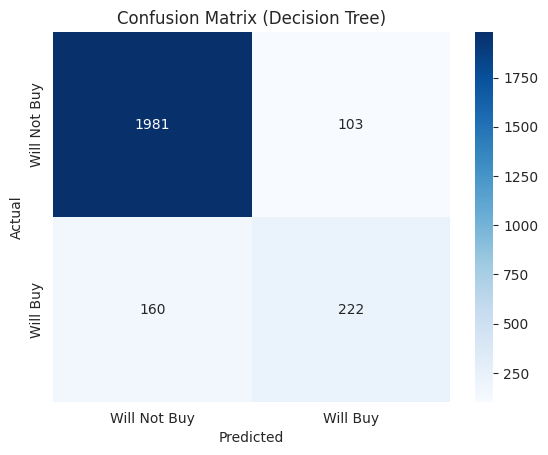

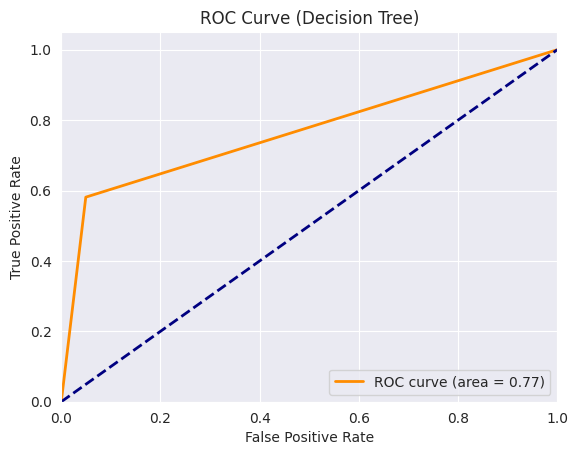

AUC: 0.7659


In [18]:
# --- 训练自定义决策树模型 ---
print("\n--- 训练自定义决策树模型 ---")
tree_model = MyDecisionTreeClassifier(max_depth=5, min_samples_split=2, criterion='gini')
tree_model.fit(X_train, y_train)
y_pred_labels_tree = tree_model.predict(X_test)
print("\n--- 决策树模型评估 ---")
accuracy_tree = accuracy_score(y_test, y_pred_labels_tree)
print(f"Accuracy: {accuracy_tree:.4f}")
print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels_tree, target_names=['Will Not Buy (0)', 'Will Buy (1)']))
print("\n混淆矩阵:")
cm_tree = confusion_matrix(y_test, y_pred_labels_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()
# ROC曲线和AUC
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_pred_labels_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)
plt.figure()
plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc_tree:.4f}")

In [19]:
import numpy as np


class MyGaussianNaiveBayes:
    def __init__(self):
        self.class_priors_ = None
        self.class_means_ = None
        self.class_vars_ = None  # 或者 stds_
        self.classes_ = None
        self.epsilon = 1e-9  # 防止除以零或log(0)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.class_priors_ = np.zeros(n_classes)
        self.class_means_ = np.zeros((n_classes, n_features))
        self.class_vars_ = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]  # 取出类别c的所有样本
            self.class_priors_[idx] = X_c.shape[0] / n_samples
            self.class_means_[idx, :] = X_c.mean(axis=0)
            self.class_vars_[idx, :] = X_c.var(axis=0) + self.epsilon  # 添加epsilon防止方差为0

    def _pdf(self, class_idx, x_row):  # x_row是单个样本的特征向量
        mean = self.class_means_[class_idx]
        var = self.class_vars_[class_idx]
        # log_pdf = -0.5 * np.sum(np.log(2. * np.pi * var)) - 0.5 * np.sum(((x_row - mean) ** 2) / var)
        # 直接计算概率，但要注意下溢风险，通常用log-sum-exp技巧
        numerator = np.exp(-((x_row - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator  # 这会返回每个特征的P(xj|yk)

    def _calculate_log_class_probability(self, class_idx, x_row):
        log_prior = np.log(self.class_priors_[class_idx] + self.epsilon)

        mean = self.class_means_[class_idx]
        var = self.class_vars_[class_idx]  # var = std^2

        # log( P(xj | yk) ) = -log(sqrt(2*pi*var_j)) - (xj - mean_j)^2 / (2*var_j)
        log_likelihood_terms = -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x_row - mean) ** 2) / var
        log_likelihood = np.sum(log_likelihood_terms)

        return log_prior + log_likelihood

    def predict_proba(self, X):  # 返回每个类别的对数后验概率（未归一化）或归一化概率
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        log_posteriors = np.zeros((n_samples, n_classes))

        for i in range(n_samples):
            for class_idx in range(n_classes):
                log_posteriors[i, class_idx] = self._calculate_log_class_probability(class_idx, X[i])

        # 归一化得到概率 (可选，如果只需要类别可以省略)
        # log_sum_exp 技巧避免下溢/上溢
        max_log = np.max(log_posteriors, axis=1, keepdims=True)
        log_posteriors_shifted = log_posteriors - max_log
        exp_log_posteriors_shifted = np.exp(log_posteriors_shifted)
        sum_exp = np.sum(exp_log_posteriors_shifted, axis=1, keepdims=True)
        probabilities = exp_log_posteriors_shifted / sum_exp
        return probabilities

    def predict(self, X):
        predictions = []
        for x_row in X:
            posteriors = []
            for class_idx, c in enumerate(self.classes_):
                log_posterior = self._calculate_log_class_probability(class_idx, x_row)
                posteriors.append(log_posterior)
            predictions.append(self.classes_[np.argmax(posteriors)])
        return np.array(predictions)


--- 训练自定义朴素贝叶斯模型 ---

--- 朴素贝叶斯模型评估 ---
Accuracy: 0.2733

Classification Report👀:
                  precision    recall  f1-score   support

Will Not Buy (0)       0.97      0.14      0.25      2084
    Will Buy (1)       0.17      0.97      0.29       382

        accuracy                           0.27      2466
       macro avg       0.57      0.56      0.27      2466
    weighted avg       0.84      0.27      0.26      2466


混淆矩阵:


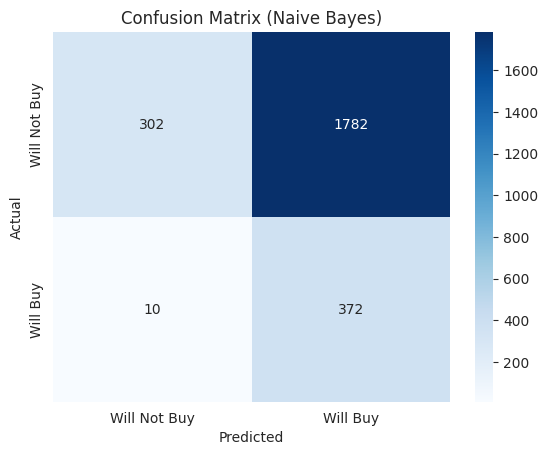

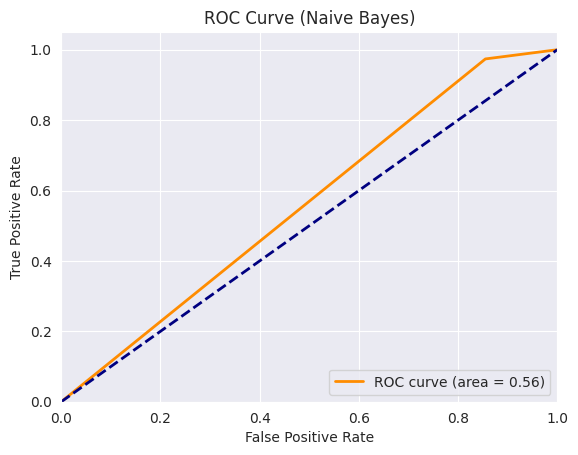

AUC: 0.5594


In [20]:
# --- 训练自定义朴素贝叶斯模型 ---
print("\n--- 训练自定义朴素贝叶斯模型 ---")
nb_model = MyGaussianNaiveBayes()
nb_model.fit(X_train, y_train)
y_pred_labels_nb = nb_model.predict(X_test)
print("\n--- 朴素贝叶斯模型评估 ---")
accuracy_nb = accuracy_score(y_test, y_pred_labels_nb)
print(f"Accuracy: {accuracy_nb:.4f}")
print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels_nb, target_names=['Will Not Buy (0)', 'Will Buy (1)']))
print("\n混淆矩阵:")
cm_nb = confusion_matrix(y_test, y_pred_labels_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()
# ROC曲线和AUC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_labels_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.figure()
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Naive Bayes)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc_nb:.4f}")

In [21]:
import numpy as np
from collections import Counter


class MyKNearestNeighbors:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _predict_single(self, x_test_sample):
        distances = [self._euclidean_distance(x_test_sample, x_train_sample) for x_train_sample in self.X_train]
        # 获取k个最近邻的索引
        k_indices = np.argsort(distances)[:self.k]
        # 获取k个最近邻的标签
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # 多数投票
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def predict(self, X_test):
        predictions = [self._predict_single(x_test_sample) for x_test_sample in X_test]
        return np.array(predictions)


--- 训练自定义KNN模型 ---

--- KNN模型评估 ---
Accuracy: 0.8719

Classification Report👀:
                  precision    recall  f1-score   support

Will Not Buy (0)       0.90      0.96      0.93      2084
    Will Buy (1)       0.64      0.39      0.48       382

        accuracy                           0.87      2466
       macro avg       0.77      0.67      0.71      2466
    weighted avg       0.86      0.87      0.86      2466


混淆矩阵:


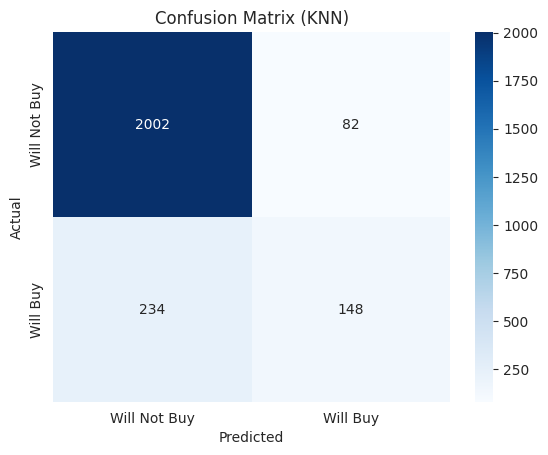

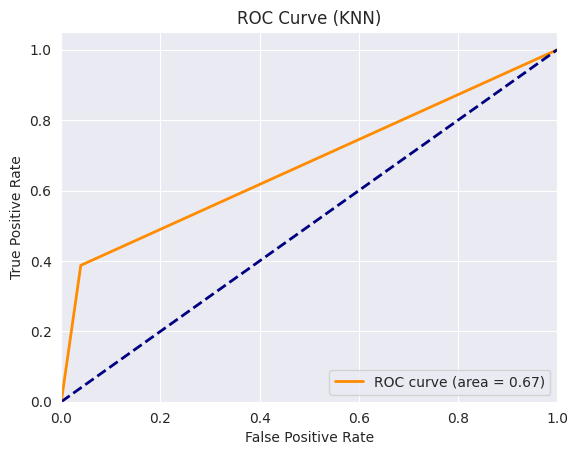

AUC: 0.6740


In [22]:
# --- 训练自定义KNN模型 ---
print("\n--- 训练自定义KNN模型 ---")
knn_model = MyKNearestNeighbors(k=5)  # k值可以调整
knn_model.fit(X_train, y_train)
y_pred_labels_knn = knn_model.predict(X_test)
print("\n--- KNN模型评估 ---")
accuracy_knn = accuracy_score(y_test, y_pred_labels_knn)
print(f"Accuracy: {accuracy_knn:.4f}")
print("\nClassification Report👀:")
print(classification_report(y_test, y_pred_labels_knn, target_names=['Will Not Buy (0)', 'Will Buy (1)']))
print("\n混淆矩阵:")
cm_knn = confusion_matrix(y_test, y_pred_labels_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Will Not Buy', 'Will Buy'],
            yticklabels=['Will Not Buy', 'Will Buy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (KNN)')
plt.show()
# ROC曲线和AUC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_labels_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc_knn:.4f}")